In [1]:
!pip install xgboost

**Install & Import Libraries**

We install and import XGBoost along with other standard libraries for model training, evaluation, and plotting.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

**Load Titanic Dataset**

We use the Titanic dataset from Kaggle, which contains passenger information such as:
- Name, Age, Gender, Ticket Class, Fare, etc.

Our goal is to **predict whether a passenger survived or not (binary classification)** based on these features.


In [10]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [11]:
train[:10]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


**Preprocess Data**

Real-world datasets often have missing values and irrelevant features. We:
- Drop non-informative columns: `Name`, `Ticket`, `Cabin`, `PassengerId`
- Fill missing values in `Age` and `Embarked`
- Convert categorical variables (`Sex`, `Embarked`) using one-hot encoding

This step ensures the dataset is clean and numerical for XGBoost.

In [13]:
train.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True)

In [14]:
train[:10]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


In [15]:
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)


/tmp/ipykernel_36/1142090327.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
/tmp/ipykernel_36/1142090327.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [16]:
train = pd.get_dummies(train, columns=['Sex', 'Embarked'], drop_first=True)

**Split into Train and Validation Sets**

We split the dataset into:
- **Training set (80%)** for learning
- **Validation set (20%)** for performance evaluation

We stratify by the target variable to maintain class balance in both sets.


In [17]:
# Split
X = train.drop('Survived', axis=1)
y = train['Survived']


In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Train XGBoost Model (with Tuning)**

We create an `XGBClassifier` with tuned hyperparameters:
- `n_estimators=100`: number of boosting rounds
- `max_depth=4`: control tree depth
- `learning_rate=0.05`: smaller steps for better generalization

This configuration makes the model **robust and less prone to overfitting**.

In [26]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_val, y_val)], verbose=False)


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**Evaluate Performance**

We evaluate the trained model using:
- **Accuracy**: overall correct predictions
- **Classification report**: precision, recall, F1-score
- **Confusion matrix**: breakdown of true vs false predictions

This gives a complete picture of how well the model generalizes.

In [27]:
y_pred = xgb.predict(X_val)


In [29]:
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


XGBoost Accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       110
           1       0.87      0.58      0.70        69

    accuracy                           0.80       179
   macro avg       0.83      0.76      0.78       179
weighted avg       0.82      0.80      0.79       179



**Visualize Confusion Matrix**

We use a heatmap to visualize the confusion matrix:
- Diagonal = correct predictions
- Off-diagonal = misclassifications

This helps identify where the model is making mistakes (e.g., predicting survival for those who didn’t).

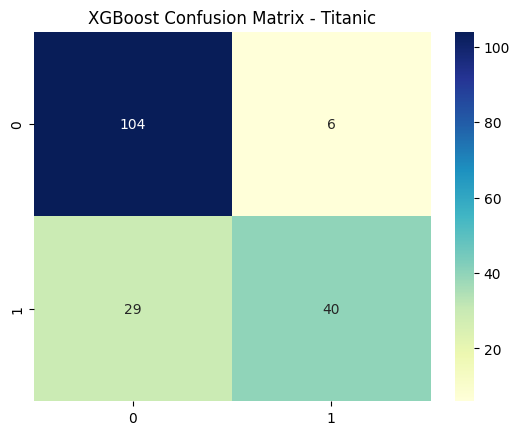

In [30]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("XGBoost Confusion Matrix - Titanic")
plt.show()

**Plot Feature Importances**

XGBoost can rank features based on their contribution to predictions (gain-based importance).  
This helps us understand:
- Which features are driving the model
- Which ones could be removed or tuned further

Common important features include: `Sex_male`, `Pclass`, `Fare`, and `Age`.

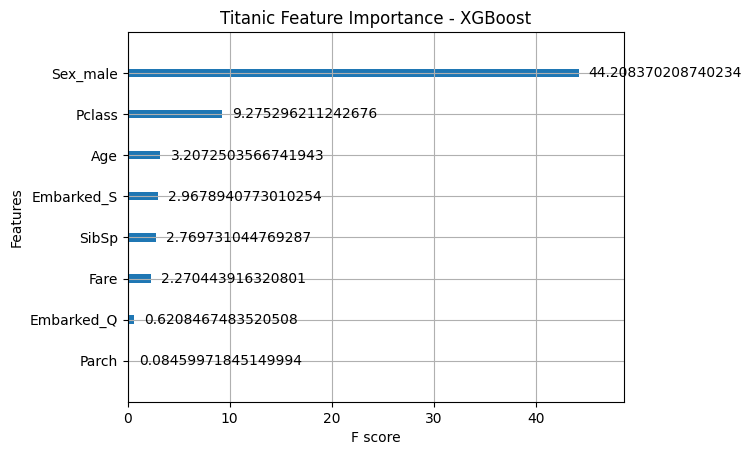

In [31]:
plot_importance(xgb, importance_type='gain')
plt.title("Titanic Feature Importance - XGBoost")
plt.show()


**Conclusion & Learnings**

- On the Titanic dataset, accuracy was only ~80%, it was more stable and generalizable.
- XGBoost handles:
  - Missing values
  - Complex interactions (e.g., Sex + Pclass + Age)
  - Overfitting control via early stopping and regularization

**Key Takeaway**

XGBoost shines when the data is **real-world, messy, imbalanced, and has feature complexity**.

In contrast, simpler models like Decision Tree or Random Forest:
- Either overfit the noise
- Or miss deeper interactions
- And can’t leverage boosting

This experiment proves that **XGBoost is better suited for production-level tabular data**.
